
# Project: Investigate European Soccer Datasets
## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
<li><a href="#conclusions">Conclusions</a></li>
</ul>

<a id='intro'></a>
## Introduction


World Cup is a huge soccer summit every four years. Although I am not a huge soccer fan of any player or team, I still enjoy watching world cup and buying sport lotteries. This dataset gives me a broad view of teams and players of European Leagues, which is almost 90% of best soccer players around the world. I am interested in investigating these questions listed below that might be helpful for me to make better predictions of next World Cup matches.

1. What are the most powerful skills that a good soccer player must have?  
2. Do star players make a huge difference to match results?
3. Are match results related to the sum of overall rating of players?



In [1]:
import pandas as pd
import numpy as np
from numpy.polynomial.polynomial import polyfit
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3
from pandas.plotting import scatter_matrix
%matplotlib inline

<a id='wrangling'></a>
## Data Wrangling

### General Properties and Data Cleaning 

Read all tables from the sqlite database and merge some tables that are relatively small. 

In [2]:
# Load your data and print out a few lines. Perform operations to inspect data
#   types and look for instances of missing or possibly errant data.


# Create your connection.
cnx = sqlite3.connect('database.sqlite')

df_country = pd.read_sql_query("SELECT * FROM Country", cnx)
df_league = pd.read_sql_query("SELECT * FROM League", cnx)
df_match = pd.read_sql_query("SELECT * FROM Match", cnx)
df_player = pd.read_sql_query("SELECT * FROM Player", cnx)
df_player_attributes = pd.read_sql_query("SELECT * FROM Player_Attributes", cnx)
df_team = pd.read_sql_query("SELECT * FROM Team", cnx)
df_team_attributes = pd.read_sql_query("SELECT * FROM Team_Attributes", cnx)


### Combine country and league tables since they have the same id numbers

In [3]:
df_country_league =  df_country.merge(df_league, left_on = 'id', right_on = 'country_id')[['name_x','country_id','name_y']]
df_country_league.rename(index = str, columns = {'name_x':'country_name','name_y':'league_name'}, inplace = True)
df_country_league

,country_name,country_id,league_name
0,Belgium,1,Belgium Jupiler League
1,England,1729,England Premier League
2,France,4769,France Ligue 1
3,Germany,7809,Germany 1. Bundesliga
4,Italy,10257,Italy Serie A
5,Netherlands,13274,Netherlands Eredivisie
6,Poland,15722,Poland Ekstraklasa
7,Portugal,17642,Portugal Liga ZON Sagres
8,Scotland,19694,Scotland Premier League
9,Spain,21518,Spain LIGA BBVA


In [4]:
df_match.head(1)

,id,country_id,league_id,season,stage,date,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,...,SJA,VCH,VCD,VCA,GBH,GBD,GBA,BSH,BSD,BSA
0,1,1,1,2008/2009,1,2008-08-17 00:00:00,492473,9987,9993,1,...,4.0,1.65,3.4,4.5,1.78,3.25,4.0,1.73,3.4,4.2


I don't know the soccer terminologies at the end of this table, so I decided to ignore that part and only have match date, season, result and player ids in the match table. Merging the `country_league` table to the `match` table makes it easier to investigate the relationship of leagues/countries with match results.

In [5]:
df = df_match.iloc[:,[0,1,3,5,6,7,8,9,10,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76]]
df_match = df_country_league.merge(df,on = 'country_id')

In [7]:
df_match.head()

,country_name,country_id,league_name,id,season,date,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,...,away_player_2,away_player_3,away_player_4,away_player_5,away_player_6,away_player_7,away_player_8,away_player_9,away_player_10,away_player_11
0,Belgium,1,Belgium Jupiler League,1,2008/2009,2008-08-17 00:00:00,492473,9987,9993,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Belgium,1,Belgium Jupiler League,2,2008/2009,2008-08-16 00:00:00,492474,10000,9994,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Belgium,1,Belgium Jupiler League,3,2008/2009,2008-08-16 00:00:00,492475,9984,8635,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Belgium,1,Belgium Jupiler League,4,2008/2009,2008-08-17 00:00:00,492476,9991,9998,5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Belgium,1,Belgium Jupiler League,5,2008/2009,2008-08-16 00:00:00,492477,7947,9985,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
df_match.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25979 entries, 0 to 25978
Data columns (total 33 columns):
country_name        25979 non-null object
country_id          25979 non-null int64
league_name         25979 non-null object
id                  25979 non-null int64
season              25979 non-null object
date                25979 non-null object
match_api_id        25979 non-null int64
home_team_api_id    25979 non-null int64
away_team_api_id    25979 non-null int64
home_team_goal      25979 non-null int64
away_team_goal      25979 non-null int64
home_player_1       24755 non-null float64
home_player_2       24664 non-null float64
home_player_3       24698 non-null float64
home_player_4       24656 non-null float64
home_player_5       24663 non-null float64
home_player_6       24654 non-null float64
home_player_7       24752 non-null float64
home_player_8       24670 non-null float64
home_player_9       24706 non-null float64
home_player_10      24543 non-null float64
home_p

We have some missing player list for some matches and the value can't be filled with average or mean value since they are player ID. I decided to drop those matches with missing values.

In [9]:
df_match.dropna(axis=0, inplace = True)

Text(0, 0.5, 'Times')

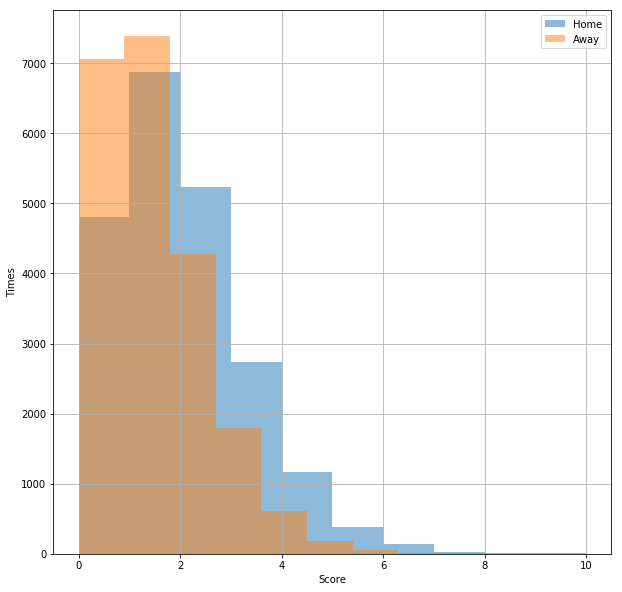

In [11]:
def plotting(col_name, label, size):
    col_name.hist(figsize = size, alpha = 0.5, label = label)
    
plotting(df_match.home_team_goal, 'Home',(10,10))
plotting(df_match.away_team_goal, 'Away',(10,10))
plt.legend()
plt.xlabel('Score')
plt.ylabel('Times')

Home teams are typically getting more scores than away teams. 

Checked there's no missing value in the dataframe anymore. <br>
The other important dataframe for my analysis is the player dataframe. <br>I am planning to combine the player dataframe with player attribute dataframe since they are relevent and easy to be combined.

In [12]:
df_player.head()


,id,player_api_id,player_name,player_fifa_api_id,birthday,height,weight
0,1,505942,Aaron Appindangoye,218353,1992-02-29 00:00:00,182.88,187
1,2,155782,Aaron Cresswell,189615,1989-12-15 00:00:00,170.18,146
2,3,162549,Aaron Doran,186170,1991-05-13 00:00:00,170.18,163
3,4,30572,Aaron Galindo,140161,1982-05-08 00:00:00,182.88,198
4,5,23780,Aaron Hughes,17725,1979-11-08 00:00:00,182.88,154


In [13]:
df_player_attributes.head()

,id,player_fifa_api_id,player_api_id,date,overall_rating,potential,preferred_foot,attacking_work_rate,defensive_work_rate,crossing,...,vision,penalties,marking,standing_tackle,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes
0,1,218353,505942,2016-02-18 00:00:00,67.0,71.0,right,medium,medium,49.0,...,54.0,48.0,65.0,69.0,69.0,6.0,11.0,10.0,8.0,8.0
1,2,218353,505942,2015-11-19 00:00:00,67.0,71.0,right,medium,medium,49.0,...,54.0,48.0,65.0,69.0,69.0,6.0,11.0,10.0,8.0,8.0
2,3,218353,505942,2015-09-21 00:00:00,62.0,66.0,right,medium,medium,49.0,...,54.0,48.0,65.0,66.0,69.0,6.0,11.0,10.0,8.0,8.0
3,4,218353,505942,2015-03-20 00:00:00,61.0,65.0,right,medium,medium,48.0,...,53.0,47.0,62.0,63.0,66.0,5.0,10.0,9.0,7.0,7.0
4,5,218353,505942,2007-02-22 00:00:00,61.0,65.0,right,medium,medium,48.0,...,53.0,47.0,62.0,63.0,66.0,5.0,10.0,9.0,7.0,7.0


In [14]:
df_player_full = df_player_attributes.merge(df_player, on = 'player_api_id')
df_player_full.drop(['id_y', 'player_fifa_api_id_y'], axis = 1,inplace = True)
df_player_full.rename(index = str, columns={'id_x':'id','player_fifa_api_id_x':'player_fifa_api_id'} ,inplace = True)

In [15]:
df_player_full.isna().sum()

id                        0
player_fifa_api_id        0
player_api_id             0
date                      0
overall_rating          836
potential               836
preferred_foot          836
attacking_work_rate    3230
defensive_work_rate     836
crossing                836
finishing               836
heading_accuracy        836
short_passing           836
volleys                2713
dribbling               836
curve                  2713
free_kick_accuracy      836
long_passing            836
ball_control            836
acceleration            836
sprint_speed            836
agility                2713
reactions               836
balance                2713
shot_power              836
jumping                2713
stamina                 836
strength                836
long_shots              836
aggression              836
interceptions           836
positioning             836
vision                 2713
penalties               836
marking                 836
standing_tackle     

Since I want to evaluate the relationship between overall rating and skills, if the overall rating value is missing for a player, it's a useless data point.<br> I am going to delete those rows with overall rating missing values.

In [16]:
df_player_full = df_player_full[df_player_full.overall_rating.isna() == 0]

In [17]:
df_player_full.isna().sum()

id                        0
player_fifa_api_id        0
player_api_id             0
date                      0
overall_rating            0
potential                 0
preferred_foot            0
attacking_work_rate    2394
defensive_work_rate       0
crossing                  0
finishing                 0
heading_accuracy          0
short_passing             0
volleys                1877
dribbling                 0
curve                  1877
free_kick_accuracy        0
long_passing              0
ball_control              0
acceleration              0
sprint_speed              0
agility                1877
reactions                 0
balance                1877
shot_power                0
jumping                1877
stamina                   0
strength                  0
long_shots                0
aggression                0
interceptions             0
positioning               0
vision                 1877
penalties                 0
marking                   0
standing_tackle     

There are still eight features in the dataframe with missing values. <br>
It's easier for me to delete those columns and only consider other features as relevant features to the overall rating. 

In [18]:
df_player_full.drop(['attacking_work_rate','volleys','curve','agility','balance','jumping','vision','sliding_tackle'],axis =1, inplace = True)

In [19]:
df_player_full.info()

<class 'pandas.core.frame.DataFrame'>
Index: 183142 entries, 0 to 183977
Data columns (total 38 columns):
id                     183142 non-null int64
player_fifa_api_id     183142 non-null int64
player_api_id          183142 non-null int64
date                   183142 non-null object
overall_rating         183142 non-null float64
potential              183142 non-null float64
preferred_foot         183142 non-null object
defensive_work_rate    183142 non-null object
crossing               183142 non-null float64
finishing              183142 non-null float64
heading_accuracy       183142 non-null float64
short_passing          183142 non-null float64
dribbling              183142 non-null float64
free_kick_accuracy     183142 non-null float64
long_passing           183142 non-null float64
ball_control           183142 non-null float64
acceleration           183142 non-null float64
sprint_speed           183142 non-null float64
reactions              183142 non-null float64
shot_power

In [20]:
df_player_full.describe()

,id,player_fifa_api_id,player_api_id,overall_rating,potential,crossing,finishing,heading_accuracy,short_passing,dribbling,...,penalties,marking,standing_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes,height,weight
count,183142.000000,183142.000000,183142.000000,183142.000000,183142.000000,183142.000000,183142.000000,183142.000000,183142.000000,183142.000000,...,183142.000000,183142.000000,183142.000000,183142.000000,183142.000000,183142.000000,183142.000000,183142.000000,183142.000000,183142.000000
mean,91978.031265,165826.723040,136294.314139,68.600015,73.460353,55.086883,49.921078,57.266023,62.429672,59.175154,...,55.003986,46.772242,50.351257,14.704393,16.063612,20.998362,16.132154,16.441439,181.875925,168.769463
std,53116.611471,53782.559432,137080.717171,7.041139,6.592271,17.242135,19.038705,16.488905,14.194068,17.744688,...,15.546519,21.227667,21.483706,16.865467,15.867382,21.452980,16.099175,17.198155,6.394896,15.088820
min,1.000000,2.000000,2625.000000,33.000000,39.000000,1.000000,1.000000,1.000000,3.000000,1.000000,...,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,157.480000,117.000000
25%,45985.250000,155885.000000,34952.000000,64.000000,69.000000,45.000000,34.000000,49.000000,57.000000,52.000000,...,45.000000,25.000000,29.000000,7.000000,8.000000,8.000000,8.000000,8.000000,177.800000,159.000000
50%,91958.500000,183527.000000,78411.000000,69.000000,74.000000,59.000000,53.000000,60.000000,65.000000,64.000000,...,57.000000,50.000000,56.000000,10.000000,11.000000,12.000000,11.000000,11.000000,182.880000,168.000000
75%,137972.750000,199912.000000,191616.000000,73.000000,78.000000,68.000000,65.000000,68.000000,72.000000,72.000000,...,67.000000,66.000000,69.000000,13.000000,15.000000,15.000000,15.000000,15.000000,185.420000,179.000000
max,183978.000000,234141.000000,750584.000000,94.000000,97.000000,95.000000,97.000000,98.000000,97.000000,97.000000,...,96.000000,96.000000,95.000000,94.000000,93.000000,97.000000,96.000000,96.000000,208.280000,243.000000


In [21]:
df_player_full.corr().overall_rating

id                   -0.002875
player_fifa_api_id   -0.274089
player_api_id        -0.322389
overall_rating        1.000000
potential             0.766757
crossing              0.357699
finishing             0.329298
heading_accuracy      0.314099
short_passing         0.458361
dribbling             0.354324
free_kick_accuracy    0.349592
long_passing          0.435018
ball_control          0.444257
acceleration          0.245655
sprint_speed          0.254841
reactions             0.769246
shot_power            0.427996
stamina               0.327456
strength              0.318661
long_shots            0.392382
aggression            0.323934
interceptions         0.250370
positioning           0.370019
penalties             0.393189
marking               0.133377
standing_tackle       0.165349
gk_diving             0.027976
gk_handling           0.004410
gk_kicking            0.025682
gk_positioning        0.005709
gk_reflexes           0.005687
height               -0.003475
weight  

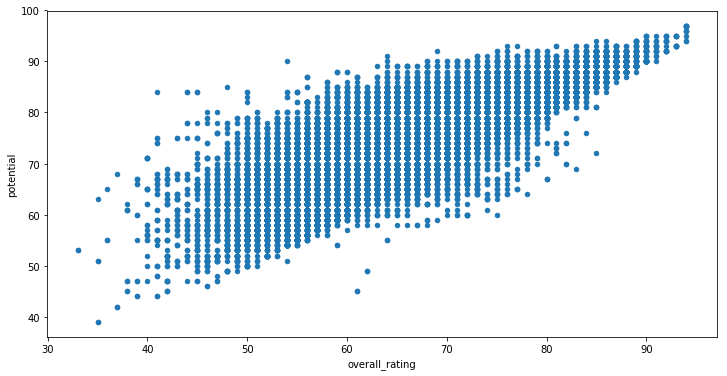

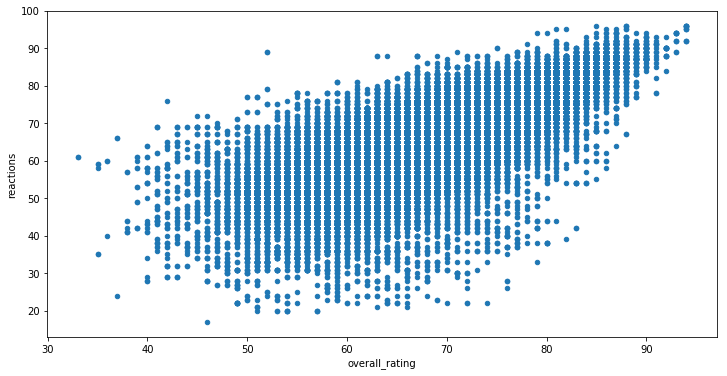

In [22]:
df_player_full.plot('overall_rating', 'potential', kind= 'scatter',figsize = (12,6))
df_player_full.plot('overall_rating','reactions', kind = 'scatter',figsize = (12,6))

`Overall_rating` has strong relationship with `Potentials` and `Reactions`. <br>
Both features correlation coefficients with `Overall_rating` is higher than 0.7. 

In [23]:
df_team.head()

,id,team_api_id,team_fifa_api_id,team_long_name,team_short_name
0,1,9987,673.0,KRC Genk,GEN
1,2,9993,675.0,Beerschot AC,BAC
2,3,10000,15005.0,SV Zulte-Waregem,ZUL
3,4,9994,2007.0,Sporting Lokeren,LOK
4,5,9984,1750.0,KSV Cercle Brugge,CEB


In [24]:
df_team_attributes.head()

,id,team_fifa_api_id,team_api_id,date,buildUpPlaySpeed,buildUpPlaySpeedClass,buildUpPlayDribbling,buildUpPlayDribblingClass,buildUpPlayPassing,buildUpPlayPassingClass,...,chanceCreationShooting,chanceCreationShootingClass,chanceCreationPositioningClass,defencePressure,defencePressureClass,defenceAggression,defenceAggressionClass,defenceTeamWidth,defenceTeamWidthClass,defenceDefenderLineClass
0,1,434,9930,2010-02-22 00:00:00,60,Balanced,NaN,Little,50,Mixed,...,55,Normal,Organised,50,Medium,55,Press,45,Normal,Cover
1,2,434,9930,2014-09-19 00:00:00,52,Balanced,48.0,Normal,56,Mixed,...,64,Normal,Organised,47,Medium,44,Press,54,Normal,Cover
2,3,434,9930,2015-09-10 00:00:00,47,Balanced,41.0,Normal,54,Mixed,...,64,Normal,Organised,47,Medium,44,Press,54,Normal,Cover
3,4,77,8485,2010-02-22 00:00:00,70,Fast,NaN,Little,70,Long,...,70,Lots,Organised,60,Medium,70,Double,70,Wide,Cover
4,5,77,8485,2011-02-22 00:00:00,47,Balanced,NaN,Little,52,Mixed,...,52,Normal,Organised,47,Medium,47,Press,52,Normal,Cover


In [25]:
df_team_full = df_team.merge(df_team_attributes, on = 'team_api_id')
df_team_full.drop(['id_y','team_fifa_api_id_y'],axis = 1, inplace = True )
df_team_full.rename(columns = {'id_x':'id','team_fifa_api_id_x':'team_fifa_api_id'},inplace = True)

In [26]:
df_team_full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1458 entries, 0 to 1457
Data columns (total 27 columns):
id                                1458 non-null int64
team_api_id                       1458 non-null int64
team_fifa_api_id                  1458 non-null float64
team_long_name                    1458 non-null object
team_short_name                   1458 non-null object
date                              1458 non-null object
buildUpPlaySpeed                  1458 non-null int64
buildUpPlaySpeedClass             1458 non-null object
buildUpPlayDribbling              489 non-null float64
buildUpPlayDribblingClass         1458 non-null object
buildUpPlayPassing                1458 non-null int64
buildUpPlayPassingClass           1458 non-null object
buildUpPlayPositioningClass       1458 non-null object
chanceCreationPassing             1458 non-null int64
chanceCreationPassingClass        1458 non-null object
chanceCreationCrossing            1458 non-null int64
chanceCreationCros

Only `buildUpPlayDribbling` is a feature with a lot of missing values, so I decided to drop this column. 

In [27]:
df_team_full.drop('buildUpPlayDribbling',axis = 1, inplace = True)

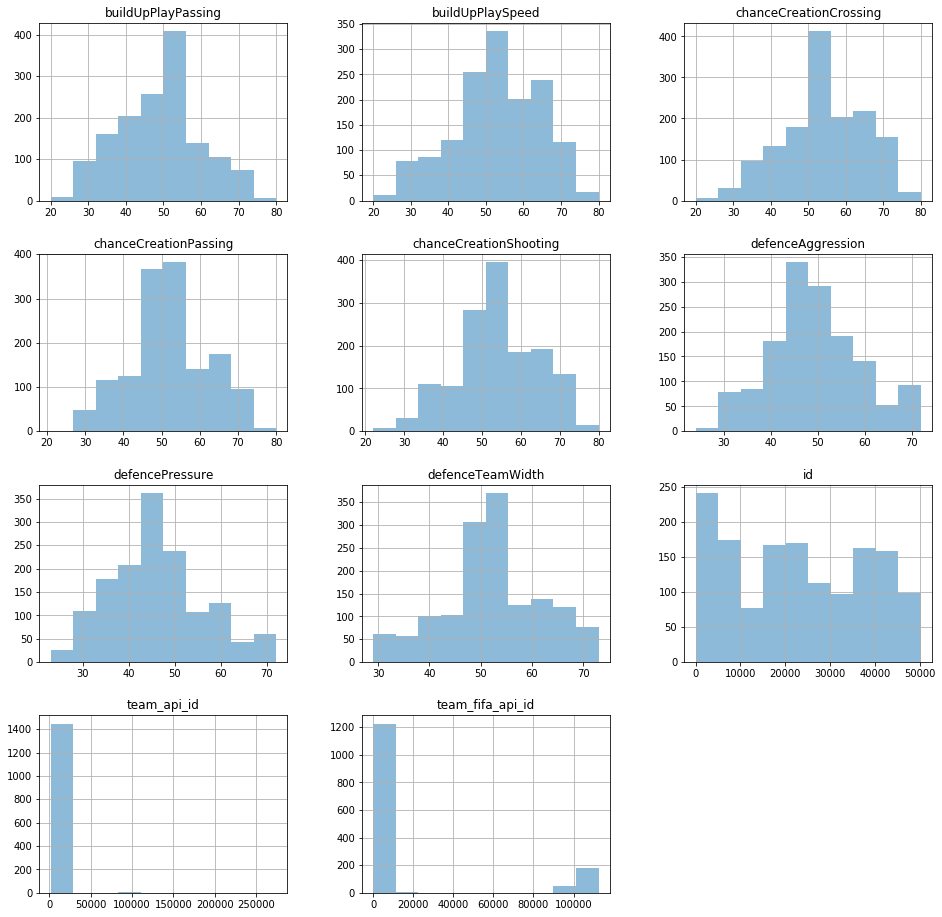

In [28]:
plotting(df_team_full, '', (16,16))

Finally cleaned up all dataframes and the final dataframes I am going to use for analysis are: <br>
1. `df_match`
2. `df_player_full`
3. `df_team_full`

<a id='eda'></a>
## Exploratory Data Analysis


### Research Question 1  What are the most powerful skills that a high performance soccer player must have?  

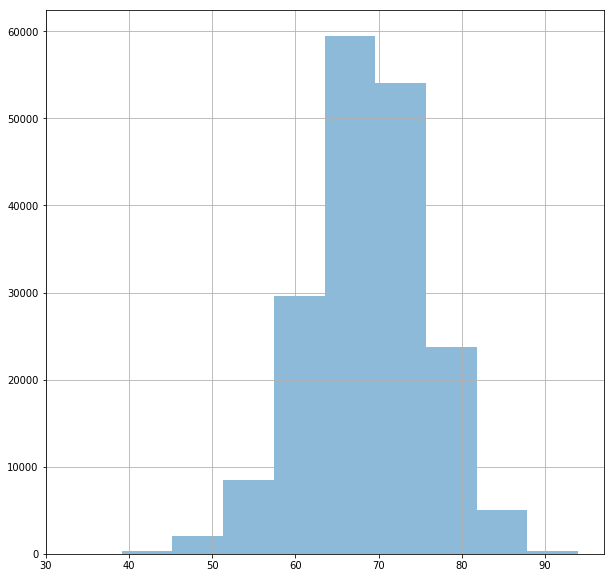

In [29]:
plotting(df_player_full.overall_rating, '', (10,10))

In [30]:
df_player_full.overall_rating.describe()

count    183142.000000
mean         68.600015
std           7.041139
min          33.000000
25%          64.000000
50%          69.000000
75%          73.000000
max          94.000000
Name: overall_rating, dtype: float64

I defined those players have overall ratings higher than two standard deviations than mean (top 5%) are hight performance players. 

In [31]:
bin_edges = [0,df_player_full.overall_rating.mean()+2*df_player_full.overall_rating.std(),100]
bin_names = ['normal','star']
df_player_full['level']=pd.cut(df_player_full['overall_rating'],bin_edges, labels = bin_names)

In [32]:
df_player_full.groupby('level').mean().T
df_star = df_player_full.groupby('level').mean().T.star


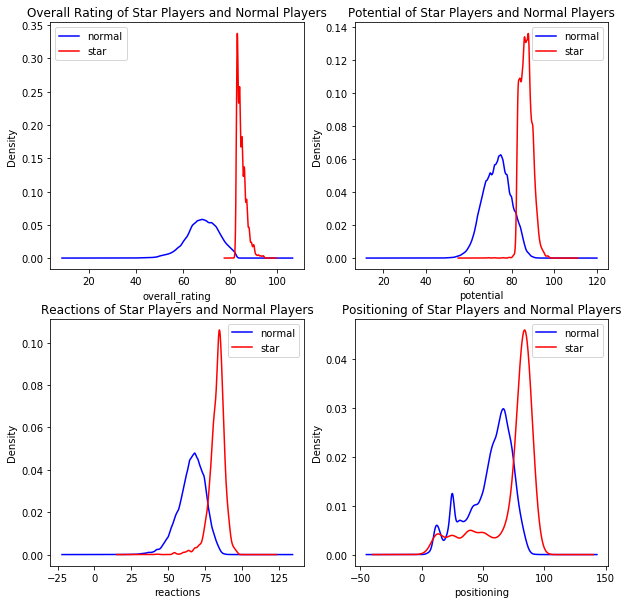

In [289]:

plt.subplot(2,2,1)

df_player_full[df_player_full.level == 'normal'].overall_rating.plot.kde(color = 'b',label = 'normal',figsize = (10,10))
df_player_full[df_player_full.level == 'star'].overall_rating.plot.kde(color = 'r',label = 'star',figsize = (10,10))
plt.xlabel('overall_rating')
plt.title('Overall Rating of Star Players and Normal Players')
plt.legend()
plt.subplot(2,2,2)
df_player_full[df_player_full.level == 'normal'].potential.plot.kde(color = 'b',label = 'normal',figsize = (10,10))
df_player_full[df_player_full.level == 'star'].potential.plot.kde(color = 'r',label = 'star',figsize = (10,10))
plt.xlabel('potential')
plt.title('Potential of Star Players and Normal Players')
plt.legend()
plt.subplot(2,2,3)
df_player_full[df_player_full.level == 'normal'].reactions.plot.kde(color = 'b',label = 'normal',figsize = (10,10))
df_player_full[df_player_full.level == 'star'].reactions.plot.kde(color = 'r',label = 'star',figsize = (10,10))
plt.xlabel('reactions')
plt.title('Reactions of Star Players and Normal Players')
plt.legend()
plt.subplot(2,2,4)
df_player_full[df_player_full.level == 'normal'].positioning.plot.kde(color = 'b',label = 'normal',figsize = (10,10))
df_player_full[df_player_full.level == 'star'].positioning.plot.kde(color = 'r',label = 'star',figsize = (10,10))
plt.xlabel('positioning')
plt.title('Positioning of Star Players and Normal Players')
plt.legend()

From the table above, we found that height and weight are not an important features to be a star player. <br>
Body fitness is not a way to predict soccer players' overall performance. <br>
I found that the above three features in the plots, `potential`, `reactions` and `positioning` are the most distinguishable features. <br>
Since the sample size of normal soccer players is much higher than star soccer players, so histagram is not a good plot to show the difference between these groups. <br>
I used `plot.kde` to show probability density function. <br>
You can see the density shape of all plots are still similar to bell shapes and peaks of `star` and `normal` group are far from each other, so these three features are great features for people to predict a soccer player's overall_rating.

### Research Question 2  Do star players make a huge difference to match results?  (Cristiano Ronaldo Specifically)

My boyfriend is a big fan of Cristiano Ronaldo, so when he knew I am going to work on this project, he asked me to research this question for him. He wants to know how powerful Cristiano Ronaldo is and how he can improve the performance of a team. 

First, I want to do more research about Cristiano Ronaldo.

In [37]:
df_ronaldo = pd.DataFrame([df_player_full[df_player_full.player_name == 'Cristiano Ronaldo'].mean(),df_star], 
                          index = ['Ronaldo','Star Player Avg'])
df_ronaldo.T


,Ronaldo,Star Player Avg
id,33343.00,93448.109291
player_fifa_api_id,20801.00,119766.052632
player_api_id,30893.00,48608.437701
overall_rating,91.28,84.827605
potential,93.48,86.859023
crossing,83.88,66.740870
finishing,91.12,65.632922
heading_accuracy,85.52,65.759130
short_passing,82.28,75.732546
dribbling,92.64,72.385875


His average overall rating 91.28, which is super high. All his performance matrices are much high than the top 5% players' average. For example, `potential`, `crossing`, `finishing` and `heading_accuracy`... etc. <br>
No doubt he is one of the most legendary player in the history. 

Let's take a look at his winning percentage of all his matches by searching for his `player_api_id` in the match player list. 

In [38]:
df_match.head().T

,145,153,155,162,168
country_name,Belgium,Belgium,Belgium,Belgium,Belgium
country_id,1,1,1,1,1
league_name,Belgium Jupiler League,Belgium Jupiler League,Belgium Jupiler League,Belgium Jupiler League,Belgium Jupiler League
id,146,154,156,163,169
season,2008/2009,2008/2009,2008/2009,2008/2009,2008/2009
date,2009-02-27 00:00:00,2009-03-08 00:00:00,2009-03-07 00:00:00,2009-03-13 00:00:00,2009-03-14 00:00:00
match_api_id,493017,493025,493027,493034,493040
home_team_api_id,8203,9984,8635,8203,10000
away_team_api_id,9987,8342,10000,8635,9999
home_team_goal,2,1,2,2,0


In [39]:
df_match.loc[df_match.home_team_goal > df_match.away_team_goal, 'result'] = 'Win'
df_match.loc[df_match.home_team_goal < df_match.away_team_goal, 'result'] = 'Lose'
df_match.loc[df_match.home_team_goal == df_match.away_team_goal, 'result'] = 'Tie'

In [40]:
df_ronaldo_home = df_match[(df_match.home_player_1 == 30893) |
         (df_match.home_player_2 == 30893) |
         (df_match.home_player_3 == 30893) |
         (df_match.home_player_4 == 30893) |
         (df_match.home_player_5 == 30893) |
         (df_match.home_player_6 == 30893) |
         (df_match.home_player_7 == 30893) |
         (df_match.home_player_8 == 30893) |
         (df_match.home_player_9 == 30893) |
         (df_match.home_player_10 == 30893) |
         (df_match.home_player_11 == 30893)] 

df_home_sum = df_ronaldo_home.groupby('result').id.count()
df_home_sum

result
Lose      8
Tie      10
Win     107
Name: id, dtype: int64

In [42]:
df_ronaldo_away = df_match[(df_match.away_player_1 == 30893) |
         (df_match.away_player_2 == 30893) |
         (df_match.away_player_3 == 30893) |
         (df_match.away_player_4 == 30893) |
         (df_match.away_player_5 == 30893) |
         (df_match.away_player_6 == 30893) |
         (df_match.away_player_7 == 30893) |
         (df_match.away_player_8 == 30893) |
         (df_match.away_player_9 == 30893) |
         (df_match.away_player_10 == 30893) |
         (df_match.away_player_11 == 30893)] 

df_away_sum = df_ronaldo_away.groupby('result').id.count()
df_away_sum.rename(index = {'Lose':'Win','Win':'Lose'}, inplace = True)
df_ronaldo_result = pd.DataFrame([df_home_sum,df_away_sum],index = ['home','away'])


Text(0.5, 1.0, 'Ronaldo Match Results Summary')

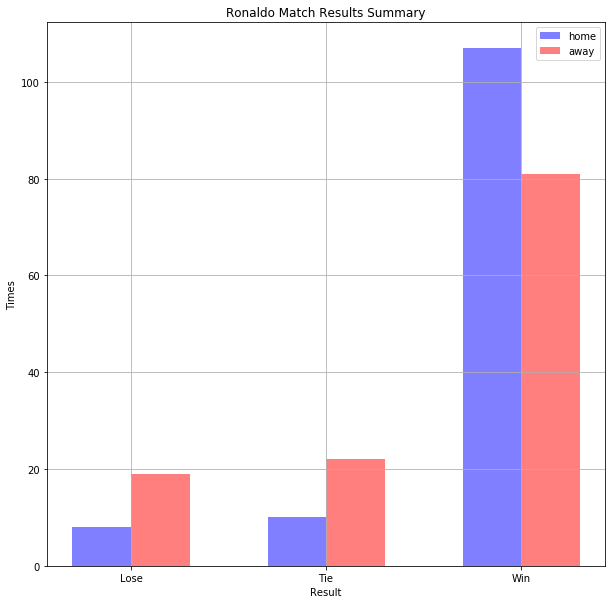

In [58]:
def multi_bar_chart(ind,width,df,label,color,size, mul):
    f, ax = plt.subplots(figsize = size)
    plt.bar(ind,df.iloc[0,:]*mul[0],width,label = label[0], color = color[0],alpha = 0.5)
    plt.bar(ind+width,df.iloc[1,:]*mul[1],width,label = label[1],color = color[1], alpha = 0.5)
    plt.legend()
    plt.xticks(ind+width/2, labels = ['Lose','Tie','Win'])
    plt.xlabel('Result')
    plt.ylabel('Times')
    plt.grid(True)
    

multi_bar_chart(ind = np.arange(3),width = 0.3, df= df_ronaldo_result, label = ['home','away'],color = ['b','r'],size = (10,10),mul = [1,1])
plt.title('Ronaldo Match Results Summary')

Within all games Ronaldo played from 2008 to 2016, he won most of the games and his winning rate of home games is high than away games.

In [47]:
pd.DataFrame([df_ronaldo_home.groupby(['home_team_api_id','season']).id.count(), df_ronaldo_away.groupby(['away_team_api_id','season']).id.count()],
            index = ['Home','Away'])


home_team_api_id     8633                                                     \
season           2009/2010 2010/2011 2011/2012 2012/2013 2013/2014 2014/2015   
Home                    11        14        19        16        13        16   
Away                    12        15        18        14        16        17   

home_team_api_id               10260  
season           2015/2016 2008/2009  
Home                    19        17  
Away                    17        13

 From the data, I know he has served two teams during 2008 to 2016 time period, so I am going to compare the winning rate of 2008/2009 of `home_team_api_id` = 10260 and the remaining seasons of `home_team_api_id` = 8633.

In [48]:
Ronaldo_2008 = df_ronaldo_home[df_ronaldo_home.season == '2008/2009'].groupby('result').id.count()+df_ronaldo_away[df_ronaldo_away.season == '2008/2009'].groupby('result').id.count()

In [49]:
Ronaldo_09to16 = df_ronaldo_home[df_ronaldo_home.season != '2008/2009'].groupby('result').id.count()+df_ronaldo_away[df_ronaldo_away.season != '2008/2009'].groupby('result').id.count()

In [50]:
pd.DataFrame([Ronaldo_2008/Ronaldo_2008.sum(),Ronaldo_09to16/Ronaldo_09to16.sum()],index = ['Team id 10260', 'Team id 8633'])

result,Lose,Tie,Win
Team id 10260,0.300000,0.133333,0.566667
Team id 8633,0.368664,0.129032,0.502304


His winning rate while serving different teams are similar, so I won't treat team as an important factor and have separate analysis for the two scienarios. The above plot `Ronaldo Match Results Summary` can represent his performance of the whole time period.

In [67]:

df_no_ronaldo_home = df_match[(df_match.home_player_1 != 30893) &
         (df_match.home_player_2 != 30893) &
         (df_match.home_player_3 != 30893) &
         (df_match.home_player_4 != 30893) &
         (df_match.home_player_5 != 30893) &
         (df_match.home_player_6 != 30893) &
         (df_match.home_player_7 != 30893) &
         (df_match.home_player_8 != 30893) &
         (df_match.home_player_9 != 30893) &
         (df_match.home_player_10 != 30893) &
         (df_match.home_player_11 != 30893) &
         (((df_match.home_team_api_id == 10260) &
         (df_match.season == '2008/2009')) | 
         ((df_match.home_team_api_id == 8633) &
         (df_match.season != '2008/2009')))]


In [66]:
df_no_ronaldo_away = df_match[(df_match.away_player_1 != 30893) &
         (df_match.away_player_2 != 30893) &
         (df_match.away_player_3 != 30893) &
         (df_match.away_player_4 != 30893) &
         (df_match.away_player_5 != 30893) &
         (df_match.away_player_6 != 30893) &
         (df_match.away_player_7 != 30893) &
         (df_match.away_player_8 != 30893) &
         (df_match.away_player_9 != 30893) &
         (df_match.away_player_10 != 30893) &
         (df_match.away_player_11 != 30893) &
         (((df_match.away_team_api_id == 10260) &
         (df_match.season == '2008/2009')) | 
         ((df_match.away_team_api_id == 8633) &
         (df_match.season != '2008/2009')))]


In [53]:
df_no_ronaldo_home_result = df_no_ronaldo_home.groupby('result').id.count()

In [54]:
df_no_ronaldo_away_result = df_no_ronaldo_away.groupby('result').id.count().rename(index = {'Win':'Lose','Lose':'Win'})

In [55]:
df_no_ronaldo_result = pd.DataFrame([df_no_ronaldo_home_result , df_no_ronaldo_away_result], index = ['home','away'])
df_no_ronaldo_result

,Lose,Tie,Win
home,2,1,14
away,5,5,16


Text(0, 0.5, 'Percentage')

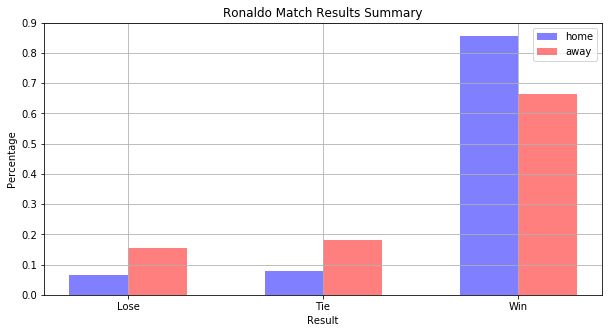

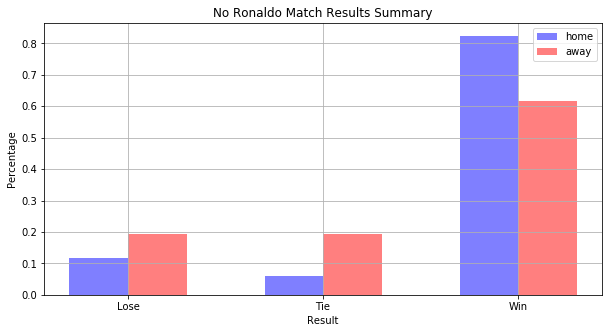

In [62]:
multi_bar_chart(ind=np.arange(3),width=0.3,
                df=df_ronaldo_result,label=['home','away'],
                color=['b','r'],size = (10,5),
                mul = [1/df_ronaldo_result.iloc[0,:].sum(),1/df_ronaldo_result.iloc[1,:].sum()])
plt.title('Ronaldo Match Results Summary')
plt.xlabel('Result')
plt.ylabel('Percentage')

multi_bar_chart(ind=np.arange(3),width=0.3,
                df=df_no_ronaldo_result,label=['home','away'],
                color=['b','r'],size = (10,5),
                mul = [1/df_no_ronaldo_result.iloc[0,:].sum(),1/df_no_ronaldo_result.iloc[1,:].sum()])
plt.title('No Ronaldo Match Results Summary')
plt.xlabel('Result')
plt.ylabel('Percentage')


### Research Question 3  3. Are match results related to the sum of overall rating of players?

In [64]:
df_rating = df_player_full.groupby('player_api_id').overall_rating.mean()
df_rating_dict = df_rating.to_dict()

In [65]:
df_match['home_1']=df_match.home_player_1.map(df_rating_dict)
df_match['home_2']=df_match.home_player_2.map(df_rating_dict)
df_match['home_3']=df_match.home_player_3.map(df_rating_dict)
df_match['home_4']=df_match.home_player_4.map(df_rating_dict)
df_match['home_5']=df_match.home_player_5.map(df_rating_dict)
df_match['home_6']=df_match.home_player_6.map(df_rating_dict)
df_match['home_7']=df_match.home_player_7.map(df_rating_dict)
df_match['home_8']=df_match.home_player_8.map(df_rating_dict)
df_match['home_9']=df_match.home_player_9.map(df_rating_dict)
df_match['home_10']=df_match.home_player_10.map(df_rating_dict)
df_match['home_11']=df_match.home_player_11.map(df_rating_dict)
df_match['away_1']=df_match.away_player_1.map(df_rating_dict)
df_match['away_2']=df_match.away_player_2.map(df_rating_dict)
df_match['away_3']=df_match.away_player_3.map(df_rating_dict)
df_match['away_4']=df_match.away_player_4.map(df_rating_dict)
df_match['away_5']=df_match.away_player_5.map(df_rating_dict)
df_match['away_6']=df_match.away_player_6.map(df_rating_dict)
df_match['away_7']=df_match.away_player_7.map(df_rating_dict)
df_match['away_8']=df_match.away_player_8.map(df_rating_dict)
df_match['away_9']=df_match.away_player_9.map(df_rating_dict)
df_match['away_10']=df_match.away_player_10.map(df_rating_dict)
df_match['away_11']=df_match.away_player_11.map(df_rating_dict)
df_match['home_rating']=df_match.iloc[:,34:44].sum(axis =1)
df_match['away_rating']=df_match.iloc[:,45:55].sum(axis =1)
df_match['goal_diff']=df_match.home_team_goal - df_match.away_team_goal
df_match['rating_diff']=df_match.home_rating - df_match.away_rating


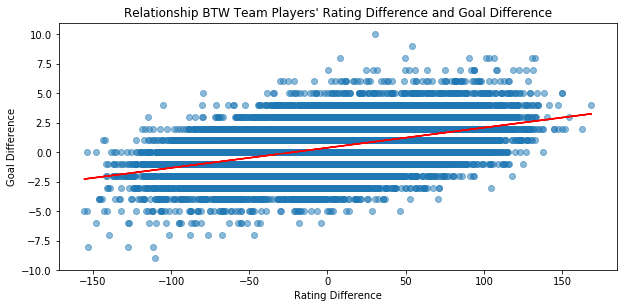

In [292]:
b, m = polyfit(df_match.rating_diff, df_match.goal_diff, 1)
plt.subplots(figsize = (10,10))
plt.subplot(2,1,1)
plt.scatter(df_match.rating_diff,df_match.goal_diff, alpha = 0.5)
plt.xlabel('Rating Difference')
plt.ylabel('Goal Difference')
plt.title("Relationship BTW Team Players' Rating Difference and Goal Difference")
plt.plot(df_match.rating_diff, b + m * df_match.rating_diff, 'r-')


In [276]:
np.corrcoef(df_match.rating_diff,df_match.goal_diff)

array([[1.        , 0.45046925],
       [0.45046925, 1.        ]])

There is a linear relationship between goal difference and overall rating difference with 0.45 correlation coefficient. Although from the scatter plot, we can see the oval shape spreading along the line, we can still say that the sum of overall rating of match players is related to the match goal difference. The trend on the plot is still following the red line.

<a id='conclusions'></a>
## Conclusions



Here is my summarize of the three questions I am interested in investigating:

1. What are the most important features to distinguish a star player from a normal player?  
I looked at the correlation coefficients and looked at the average values of all features. <br>
My analysis shows that a star player must have high potential, fast reaction speed and strong positioning.

*Limitations:* I have limited understanding of soccer player statistics, so I deleted around 15 columns from the original dataset.<br>
If I've done more research of all stats, I might be able to have a more accurate conclusion of important features for star players.


2. Do star players make a huge difference to match results? (Cristiano Ronaldo specifically) <br>
By comparing all matches Ronaldo played in the dataset and those matches of his team but without him on the feild, I found that Ronaldo only slightly increased the winning rate of his team. <br> 
(Increase from 82% to 85% for home game and 61% to 66% for away game)  <br>
However, since the sample size of matches without Ronaldo is small, the result might not be accurate. <br>
We need more matches without Ronaldo result to support this conclusion.

*Limitations:* Ronaldo played almost all matches. For example, he only missed 1 home game in the season 2008/2009. I don't have enough data points to strongly support my conclusion that matches have similar results with or without him.

3. Are match results related to the sum of overall rating of players? <br>
The difference of sum of players' overall rating has linear relationship with goals difference between the two teams.<br>
The correlation coefficient is 0.45, which shows the linear relationship but not super strong.

*Limitations:* I use the average of overall rating of players for the total rating of a team, rather than a player's overall rating of that season. I can also do overall rating query of player of the season, but that would be too complicated and I just want a quick analysis here. 